In [1]:
import sys
import os
import pandas as pd
from pytablewriter import MarkdownTableWriter
from typing import Dict, List, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

%config Completer.use_jedi = False


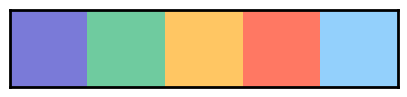

In [2]:

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.5)

plt.rcParams.update({'axes.edgecolor': 'black', 'axes.linewidth': 2, 
                     'axes.grid': False, 'grid.linestyle': '--'})
colors = ['#7a7ad8', '#6fcb9f', '#ffc663', '#ff7863', '#93d0fc']
sns.palplot(colors)
sns.set_palette(sns.color_palette(colors), 8, .75)
sub_figure_title = {"fontweight": 700, 'fontname':'Arial', 'fontsize': 18}
#plt.tight_layout()


In [3]:
#ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance"]
ALGORITHM = ["semantic-zest", "syntactic-zest", "semantic-noguidance", "syntactic-noguidance","afl"]

RANGE=20 #exclusiove range in python


In [23]:
#path = "/home/alena/source/growe/exps8"

folder = "exp_jqf_nextflow_instrument"
base_path = f"c:\\Users\\Alena\\fulldownload\\{folder}\\"


In [24]:

def process_cov_data(path: str) -> List[str]:
    with open(path, encoding="utf8") as f:
        return f.readlines()

def add_rolling_mean( data : pd.DataFrame, rolling : int = 10) -> pd.DataFrame:
    data['valid_inputs_percent']= data['valid_inputs'] / data['total_inputs']

    # rolling mean to valid_covered_probes
    data[f'rolling_{rolling}_valid_covered_probes'] = data['valid_covered_probes'].rolling(rolling).mean()
    
    # rolling mean to all_covered_probes
    data[f'rolling_{rolling}_all_covered_probes'] = data['all_covered_probes'].rolling(rolling).mean()
    
    # rolling mean to total_inputs
    data[f'rolling_{rolling}_total_inputs'] = data['total_inputs'].rolling(rolling).mean()

    data['rolling_algorithm'] = data['algorithm'].astype(str) + f"_rollingmean_{rolling}"
    
    return data

In [25]:
def p2f(value: str) -> float:
    return float(value.strip('%'))

def read_plot_data(path: str, algorithm: str, idx: int) -> pd.DataFrame:
    ps=os.path.join(path, 'plot_data')
    #print(ps)
    time_axis = "# unix_time"
    if algorithm == "afl":
        data = pd.read_csv(ps, sep=",", skipinitialspace=True,
                       converters={"valid_cov": p2f, "map_size": p2f})
    else:
        data = pd.read_csv(ps, sep=",", skipinitialspace=True)

    if data.empty: return None

    data[time_axis] -= data[time_axis][0]
  
    if algorithm != "afl":
        data['total_inputs'] = data['valid_inputs'] + data['invalid_inputs']
        data['valid_inputs_percent']= (data['valid_inputs'] / data['total_inputs'])

    x_axis = time_axis
    algo_data = data.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    
    algo_data['algorithm'] = [algorithm] * algo_data.shape[0]
    if algorithm != "afl":
        algo_data[['generator','guidance']] = algo_data['algorithm'].str.split('-', expand=True)

    algo_data['run'] = [idx] * algo_data.shape[0]
  
    return algo_data


## READ ORIGINAL DATA

In [26]:
# READ ORIGIANL DATA

original_plot_data=[] # array of original dataframes

for algorithm in ALGORITHM:
    original_data_per_algo = []

    for idx in range(0, RANGE):
        path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
        if algorithm == "afl":
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}","fuzz-results")
        if not os.path.exists(path):
            continue
        #print(f"processing: {path}")

        # plot_data from jqf afl run differs from other 
        if not algorithm == "afl" and os.path.exists(os.path.join(path,"plot_data")): 
            original_data = read_plot_data(path,algorithm,idx)
            if original_data is None:
                continue

            original_data_per_algo.append(original_data)
        
    original_plot_data.extend([d for d in original_data_per_algo])



In [27]:

def read_exception_log(path: str, algorithm: str) -> pd.DataFrame:
    ps=os.path.join(path, 'exception_log.csv')
    #print(ps)
    columns=["exception","unique","count","file","empty"]
    if algorithm != "afl":
        data = pd.read_csv(ps, sep=";", header=None,names=columns)

    if data.empty: return None
    
    data['algorithm'] = [algorithm] * data.shape[0]
  
    return data


In [28]:
# READ Exceptions

exceptions_data = []
exceptions_per_algo = []

for algorithm in ALGORITHM:
    
    for idx in range(0, RANGE):
        path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
        if not os.path.exists(path):
            continue
        #print(f"processing: {path}")
        if not algorithm == "afl" and os.path.exists(os.path.join(path,"exception_log.csv")): 
            exc = read_exception_log(path,algorithm)
            if exc is None:
                continue
            exc['run']= [idx] * exc.shape[0]
            exceptions_per_algo.append(exc)
            
exceptions_data = pd.concat(exceptions_per_algo)


In [29]:
a = exceptions_data[ exceptions_data['exception'].str.contains('Script')]

pd.set_option('display.max_rows', 30)
b=a[ a['algorithm'] == 'semantic-zest']  
b

,exception,unique,count,file,empty,algorithm,run
1,nextflow.exception.ScriptCompilationException,True,1,out1694866721541.nf,NaN,semantic-zest,0
1,nextflow.exception.ScriptCompilationException,True,1,out1695026044435.nf,NaN,semantic-zest,2
2,nextflow.exception.ScriptCompilationException,True,2,out1695028752127.nf,NaN,semantic-zest,2
1,nextflow.exception.ScriptCompilationException,True,1,out1694881334511.nf,NaN,semantic-zest,3
2,nextflow.exception.ScriptCompilationException,True,2,out1694884404428.nf,NaN,semantic-zest,3
...,...,...,...,...,...,...,...
2,nextflow.exception.ScriptCompilationException,True,2,out1694984052764.nf,NaN,semantic-zest,18
3,nextflow.exception.ScriptCompilationException,True,3,out1694984067627.nf,NaN,semantic-zest,18
4,nextflow.exception.ScriptCompilationException,True,4,out1694984172349.nf,NaN,semantic-zest,18
5,nextflow.exception.ScriptCompilationException,True,5,out1694984324429.nf,NaN,semantic-zest,18


## interpolated data

In [30]:
# interpolated data

reindexsteps =5  
interpolate = True

time_based_plot_data = [] #dataframe with interpolated runs 
count_based_plot_data = [] #dataframe with interpolated runs

first_idx=0
time_range=3600
for df in original_plot_data:
    algorithm = df['algorithm'][0]
    x_axis = "# unix_time"
    time_based_data = df.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    if interpolate:
        time_based_data = time_based_data.set_index(x_axis).reindex(
           range(1, time_range, reindexsteps)).interpolate().reset_index()
        #resetting algo because it was overwritten by interpolation
        time_based_data['algorithm'] = [algorithm] * time_based_data.shape[0]
        time_based_data[['generator','guidance']] = time_based_data['algorithm'].str.split('-', expand=True)

    time_based_data['valid_inputs_percent']= (time_based_data['valid_inputs'] / time_based_data['total_inputs'])

    time_based_plot_data.append( time_based_data)
    
    x_axis = "total_inputs"
    count_based_data = df.copy().drop_duplicates(
        keep='first', subset=[x_axis])
    if interpolate:
        count_based_data = count_based_data.set_index(x_axis).reindex(
           range(1, count_based_data[x_axis].max(), reindexsteps*8)).interpolate().reset_index()
        #resetting algo because it was overwritten by interpolation
        count_based_data['algorithm'] = [algorithm] * count_based_data.shape[0]
        count_based_data[['generator','guidance']] = count_based_data['algorithm'].str.split('-', expand=True)
        
    count_based_data['valid_inputs_percent']= (count_based_data['valid_inputs'] / count_based_data['total_inputs'])
    
    count_based_plot_data.append(count_based_data)

    
    first_idx = first_idx +1
#
time_based_plot_data = pd.concat(time_based_plot_data, ignore_index=True, sort=False)
count_based_plot_data = pd.concat(count_based_plot_data, ignore_index=True, sort=False)
 

In [31]:
time_based_plot_data


,# unix_time,cycles_done,cur_path,paths_total,pending_total,pending_favs,map_size,unique_crashes,unique_hangs,max_depth,...,invalid_inputs,valid_cov,all_covered_probes,valid_covered_probes,total_inputs,valid_inputs_percent,algorithm,generator,guidance,run
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,semantic,zest,NaN
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,semantic-zest,semantic,zest,NaN
2,11,0.0,0.0,12.000000,0.0,0.0,7666.410000,0.000000,0.0,0.0,...,7.000000,7342.97,19626.000000,18798.000000,19.000000,0.631579,semantic-zest,semantic,zest,0.0
3,16,0.0,0.0,17.333333,0.0,0.0,7838.153333,0.333333,0.0,0.0,...,10.666667,7511.98,20065.666667,19230.666667,30.000000,0.644444,semantic-zest,semantic,zest,0.0
4,21,0.0,0.0,22.666667,0.0,0.0,8009.896667,0.666667,0.0,0.0,...,14.333333,7680.99,20505.333333,19663.333333,41.000000,0.650407,semantic-zest,semantic,zest,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57595,3576,0.0,0.0,30.000000,0.0,0.0,6823.830000,1490.333333,0.0,0.0,...,7833.333333,6544.92,17469.000000,16755.000000,15903.333333,0.507441,syntactic-noguidance,syntactic,noguidance,19.0
57596,3581,0.0,0.0,30.000000,0.0,0.0,6823.830000,1491.666667,0.0,0.0,...,7837.666667,6544.92,17469.000000,16755.000000,15910.666667,0.507395,syntactic-noguidance,syntactic,noguidance,19.0
57597,3586,0.0,0.0,30.000000,0.0,0.0,6823.830000,1493.000000,0.0,0.0,...,7842.000000,6544.92,17469.000000,16755.000000,15918.000000,0.507350,syntactic-noguidance,syntactic,noguidance,19.0
57598,3591,0.0,0.0,30.000000,0.0,0.0,6823.830000,1493.000000,0.0,0.0,...,7842.000000,6544.92,17469.000000,16755.000000,15918.000000,0.507350,syntactic-noguidance,syntactic,noguidance,19.0


## rolling mean data

In [32]:
# rolling mean data

ROLLING_MEAN=50

rolling_time_based_plot_data = [] #dataframe with rolling mean over all runs
rolling_count_based_plot_data = [] #dataframe with rolling mean over all runs

complete_data_frame = pd.concat(original_plot_data, ignore_index=True, sort=False)
for algorithm in ALGORITHM:
    data_per_algo = complete_data_frame[complete_data_frame['algorithm'] == algorithm]

    if data_per_algo is None or len(data_per_algo) == 0: continue

    rolling_time_based_data_per_algo = data_per_algo.sort_values(by=['# unix_time'])
    rolling_time_based_data_per_algo = add_rolling_mean(rolling_time_based_data_per_algo, ROLLING_MEAN)
    rolling_time_based_plot_data.append(rolling_time_based_data_per_algo)

    rolling_count_based_data_per_algo = data_per_algo.sort_values(by=['total_inputs'])
    rolling_count_based_data_per_algo = add_rolling_mean(rolling_count_based_data_per_algo, ROLLING_MEAN)
    rolling_count_based_plot_data.append(rolling_count_based_data_per_algo)



 
rolling_time_based_plot_data = pd.concat(rolling_time_based_plot_data, ignore_index=True, sort=True)
rolling_count_based_plot_data = pd.concat(rolling_count_based_plot_data, ignore_index=True, sort=True)



In [33]:
complete_data_frame


,# unix_time,cycles_done,cur_path,paths_total,pending_total,pending_favs,map_size,unique_crashes,unique_hangs,max_depth,...,invalid_inputs,valid_cov,all_covered_probes,valid_covered_probes,total_inputs,valid_inputs_percent,algorithm,generator,guidance,run
0,0,0,0,1,0,0,755.47,0,0,0,...,0,755.47,1934,1934,1,1.000000,semantic-zest,semantic,zest,0
1,11,0,0,12,0,0,7666.41,0,0,0,...,7,7342.97,19626,18798,19,0.631579,semantic-zest,semantic,zest,0
2,15,0,0,16,0,0,7692.19,1,0,0,...,10,7349.22,19692,18814,27,0.629630,semantic-zest,semantic,zest,0
3,19,0,0,22,0,0,7985.55,1,0,0,...,16,7653.91,20443,19594,41,0.609756,semantic-zest,semantic,zest,0
4,23,0,0,25,0,0,8181.64,1,0,0,...,16,7850.00,20945,20096,48,0.666667,semantic-zest,semantic,zest,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118871,3590,0,0,30,0,0,6823.83,1493,0,0,...,7844,6544.92,17469,16755,15920,0.507286,syntactic-noguidance,syntactic,noguidance,19
118872,3592,0,0,30,0,0,6823.83,1494,0,0,...,7846,6544.92,17469,16755,15922,0.507223,syntactic-noguidance,syntactic,noguidance,19
118873,3593,0,0,30,0,0,6823.83,1494,0,0,...,7847,6544.92,17469,16755,15923,0.507191,syntactic-noguidance,syntactic,noguidance,19
118874,3594,0,0,30,0,0,6823.83,1494,0,0,...,7852,6544.92,17469,16755,15929,0.507063,syntactic-noguidance,syntactic,noguidance,19


In [34]:
def generate_plot_data_base(data: pd.DataFrame, rolling_data:pd.DataFrame, x_axis: str, y_axis: str, path: str, errorbarname: str = 'se'):
    print(x_axis, y_axis)
    fig, ax1 = plt.subplots(figsize=(8,6))
    #ax2 = ax1.twinx()

    if errorbarname == 'se':
        lineplot1 = sns.lineplot(x=x_axis, y=y_axis, hue='algorithm', errorbar="se", hue_order=sorted(data['algorithm'].unique()), data=data, ax=ax1)
   
    elif errorbarname == 'sd':
        lineplot1 = sns.lineplot(x=x_axis, y=y_axis, hue='algorithm', errorbar=("sd",95), hue_order=sorted(data['algorithm'].unique()), data=data, ax=ax1)    
    '''
    y2=f"rolling_{ROLLING_MEAN}_{y_axis}"
    if not y2 in rolling_data.columns:
        y2 = y_axis
    
    lineplot2 = sns.lineplot(x=x_axis, 
                             y=y2, 
                             hue='rolling_algorithm', 
                             errorbar=None, 
                             hue_order=sorted(rolling_data['rolling_algorithm'].unique()), 
                             data=rolling_data, 
                             ax=ax1, 
                             palette="Set2",
                             linestyle="dotted")
    legend2 = lineplot2.legend()

    leg_lines = legend2.get_lines()
    for line in leg_lines[4:]:
        line.set_linestyle(":")
    
    '''
        
    ax1.set_xlabel(x_axis)
    ax1.set_ylabel(y_axis)
    
    lineplot1.set(title=path.split("/")[-1][:-4].replace("_"," "))
   
    # ax2.set_ylabel(f"rolling_{ROLLING_MEAN}_{y_axis}")

    fig = ax1.get_figure()
    fig.show()
    fig.savefig(path)


In [35]:
errorbrar = 'se'
pdf_dir=f'pdfs_{folder}/'

if not os.path.exists(os.path.join(".",pdf_dir)):
    os.mkdir(os.path.join(".",pdf_dir))

    

# unix_time valid_covered_probes


C:\Users\Alena\AppData\Local\Temp\ipykernel_16920\873725491.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


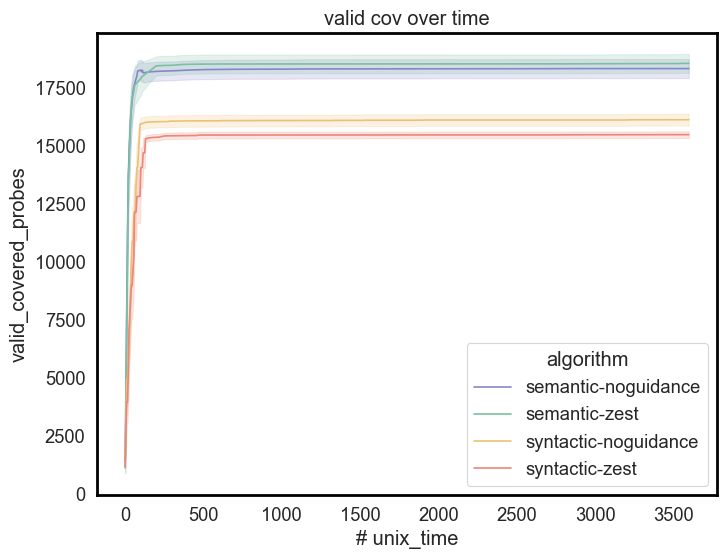

In [36]:
generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_covered_probes", f"{pdf_dir}valid_cov_over_time.pdf", 'se')


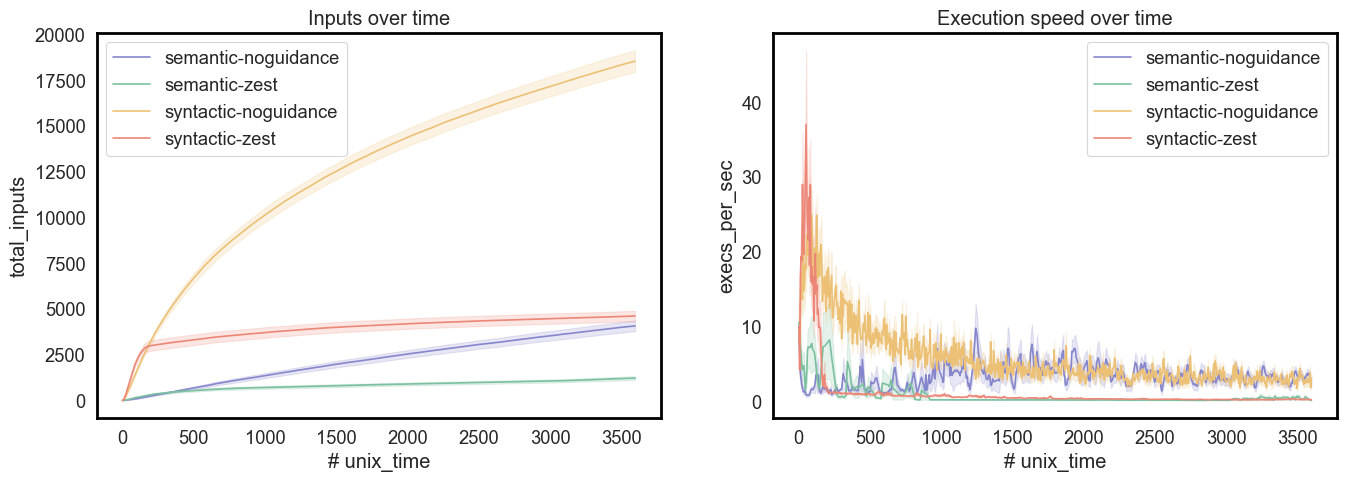

In [37]:
fig, ax1 = plt.subplots(1,2,figsize=(16,5))
x='# unix_time'
lineplot1 = sns.lineplot(x=x, y='total_inputs', hue='algorithm', errorbar="se", hue_order=sorted(time_based_plot_data['algorithm'].unique()), data=time_based_plot_data, ax=ax1[0])
lineplot1.set_title("Inputs over time")
lineplot1.legend(loc='upper left')
lineplot2 = sns.lineplot(x=x, 
                         y='execs_per_sec', 
                         hue='algorithm', 
                         errorbar="se", 
                         hue_order=sorted(time_based_plot_data['algorithm'].unique()), 
                         data=time_based_plot_data, 
                         ax=ax1[1])
lineplot2.set_title("Execution speed over time")
lineplot2.legend(loc='upper right')

path=f"{pdf_dir}/inputs_over_time.pdf"


fig.savefig(path)


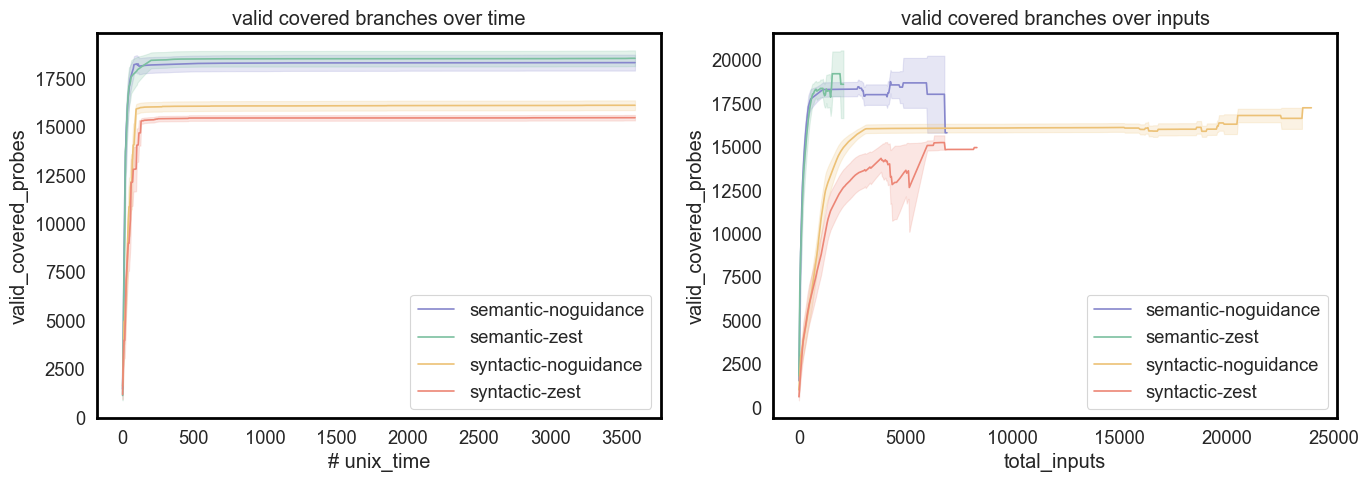

In [38]:
fig, ax1 = plt.subplots(1,2,figsize=(16,5))
x='# unix_time'
lineplot1 = sns.lineplot(x=x, y='valid_covered_probes', 
                         hue='algorithm',
                         errorbar="se",
                         hue_order=sorted(time_based_plot_data['algorithm'].unique()), 
                         data=time_based_plot_data, 
                         ax=ax1[0])
lineplot1.set_title("valid covered branches over time")
lineplot1.legend(loc='lower right')
x2='total_inputs'
lineplot2 = sns.lineplot(x=x2, 
                         y='valid_covered_probes', 
                         hue='algorithm', 
                         hue_order=sorted(count_based_plot_data['algorithm'].unique()), 
                         errorbar="se",
                         data=count_based_plot_data, 
                         ax=ax1[1])
lineplot2.set_title("valid covered branches over inputs")
lineplot2.legend(loc='lower right')

path=f"{pdf_dir}/covered_probes_time_and_inputs.pdf"


fig.savefig(path)


In [ ]:
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_inputs" , f"{pdf_dir}valid_inputs_over_time.pdf", errorbrar)

#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "invalid_inputs" , f"{pdf_dir}invalid_inputs_over_time.pdf", errorbrar)
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "all_covered_probes", f"{pdf_dir}all_cov_over_time.pdf", errorbrar)

#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "total_inputs" , f"{pdf_dir}inputs_over_time.pdf", errorbrar)
#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "valid_inputs", f"{pdf_dir}all_cov_over_time.pdf", errorbrar)

#generate_plot_data_base(time_based_plot_data, rolling_time_based_plot_data, "# unix_time", "unique_crashes", f"{pdf_dir}crashes_over_time.pdf", errorbrar)


In [ ]:
#sns.pairplot(rolling_time_based_plot_data)

In [ ]:
l ,axes  = plt.subplots(figsize=(8,6))
plot= sns.lineplot(time_based_plot_data, 
                 y='valid_inputs_percent',
                 x='# unix_time',
                 hue='algorithm', 
                 errorbar='se',
                 hue_order=sorted(time_based_plot_data['algorithm'].unique()),
                 ax= axes)
'''
sns.lineplot(rolling_time_based_plot_data, 
                 y='valid_inputs_percent',
                 x='# unix_time',
                 hue='algorithm', 
                   errorbar='se',
                 hue_order=ALGORITHM,
                 ax= axes[1])
                 
'''
plot.get_figure().savefig(f"{pdf_dir}/valid_inputs_percent_over_time.pdf")


In [ ]:
exceptions_data[10:100]


In [ ]:
for algo in ALGORITHM:
    algo_data = exceptions_data[exceptions_data['algorithm'] == algo]
    #print( algo)
    #print(algo_data['exception'].value_counts())
exceptions_count = exceptions_data.groupby(['exception','algorithm'])['algorithm'].count().to_frame()
print(exceptions_count)

exceptions_count.T

In [ ]:
unique=exceptions_data[exceptions_data['unique'] == True]

plot=sns.displot(exceptions_data, x='exception',hue='algorithm', height=4, aspect=1.5, multiple="dodge")
plot.tight_layout()

for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_ha('right')
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + 10
        value = str(int(p.get_height()))
        ax.text(_x, _y, value, ha="center")    


plot.savefig(f'{pdf_dir}/exceptions.pdf')

In [ ]:
plot.savefig((os.path.join( pdf_dir, "exceptions_logged.pdf" )))

In [ ]:
for algo in ALGORITHM:
    algodata = complete_data_frame[complete_data_frame['algorithm']==algo]
    if not algodata.empty: 
        val1 = 0
        val2 = 0
        vt = 0
        val3 = 0
        val4 = 0
        for i in range(RANGE):
            d = algodata[algodata["run"]==i]
            m1 = d['valid_inputs'].max()
            m2 =  d['invalid_inputs'].max()
            mt = d['total_inputs'].max()
            val1+=m1
            val2+=m2
            vt+=mt
            m3=m1/mt
            m4=m2/mt
            v=d['valid_inputs_percent'].max()
            #print(f"algo {algo} run {i} valid:{m1} ({m3}%)  - invalid: {m2} ({m4}%) {v}")
        val3=(val1/vt)*100
        val4=(val2/vt)*100
        print(f" {algo} & {vt} & {val1} ({val3:.2f}\%) & {val2} ({val4:.2f}\%) \\\\ \\ addlinespace")
        print("")

In [ ]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(2,2, figsize=(10,10),sharey=False)
i=0
cols = sns.color_palette("husl",20)

algo = 'semantic-zest'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[0,0],
                  palette=cols)
    plot.get_legend().set_visible(False)
    plot.set_title(algo)

algo = 'semantic-noguidance'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[0,1],
                  palette=cols)
    plot.get_legend().set_visible(False)
    plot.set_title(algo)


algo = 'syntactic-zest'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[1,0],
                  palette=cols)
    plot.get_legend().set_visible(False)
    plot.set_title(algo)



algo = 'syntactic-noguidance'
unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
if not unique.empty: 
    plot = sns.lineplot(data=unique, 
              x='# unix_time',
              y='unique_crashes' ,
              hue='run',
              hue_order=sorted(unique['run'].unique()),
              ax=axes[1,1],
                  palette=cols)
    plot.get_legend().set_visible(False)
    plot.set_title(algo)



In [ ]:
l.savefig(os.path.join( pdf_dir, "unique_crashes_per_run.pdf" ))

In [ ]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(1,4, figsize=(25,5),sharey=True)
i=0
cols = sns.color_palette("husl")

for algo in ALGORITHM:

    unique=rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'] == algo]
    if not unique.empty: 
        plot = sns.lineplot(data=unique, 
                  x='# unix_time',
                  y='valid_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes[i],
                  palette=cols)
        plot.set_title(algo)
        plot.get_legend().set_visible(False)
    i+=1

for ax in l.axes:
    ax.tick_params(axis='y', labelleft=True)
    
l.savefig(os.path.join( pdf_dir, "cov_per_run.pdf" ))


In [ ]:
#unique = unique[unique['algorithm'].isin(['semantic-noguidance','semantic-zest'])]
l, axes = plt.subplots(1,4, figsize=(25,5),sharey=True)
i=0
cols = sns.color_palette("husl")

for algo in ALGORITHM:

    unique=rolling_count_based_plot_data[rolling_count_based_plot_data['algorithm'] == algo]
    if not unique.empty: 
        plot = sns.lineplot(data=unique, 
                  x='total_inputs',
                  y='valid_covered_probes' ,
                  hue='run',
                  hue_order=sorted(unique['run'].unique()),
                  ax=axes[i],
                  palette=cols)
        plot.set_title(algo)
        plot.get_legend().set_visible(False)
    i+=1

for ax in l.axes:
    ax.tick_params(axis='y', labelleft=True)
    
l.savefig(os.path.join( pdf_dir, "cov_per_run_over_inputs.pdf" ))


In [ ]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100

for algo in ALGORITHM:
    b =complete_data_frame[complete_data_frame['algorithm'].str.match(algo)]

    total = b.groupby(['run'])['total_inputs'].last()
    val = b.groupby(['run'])['valid_inputs'].last() 
    valper = b.groupby(['run'])['valid_inputs_percent'].last()

    total_mean  = total.mean()
    val_mean= val.mean()
    valper_mean = valper.mean()

    total_std = cv(total)
    val_std = cv(val)
    valper_std = cv(valper)
    
    print(f"{algo} & {total_mean:.0f} ({total_std:.2f}\%) &  {val_mean:.0f} ({val_std:.2f}\%) & {valper_mean*100:.2f} ({valper_std:.2f}\%) ")
    
    


In [ ]:
data = complete_data_frame[complete_data_frame['# unix_time'] >= 3550]


print(data.groupby(['run','algorithm']).agg({'valid_covered_probes':['min','max','std']}))


In [ ]:
print(data.groupby(['run','algorithm'])['valid_covered_probes'].last())


In [ ]:
def read_exceptions_from_jqf_log(path: str, algorithm: str) -> pd.DataFrame:
    ps=os.path.join(path, 'jqf.log')
    #print(ps)
    columns=["exception","count"]
    data={
        "exception":[]
    }
    lines = process_cov_data(ps)
    for l in lines:
        if "ERROR" in l:
            ex = l.replace("ERROR ~ ","")
            data["exception"].append(ex.split(":")[0].strip())
    #print(data)
    data = pd.DataFrame(data)
    
    if data.empty: return None
    
    data['algorithm'] = [algorithm] * data.shape[0]
  
    return data

In [ ]:
# READ Exceptions

exceptions_data = []
exceptions_per_algo = []

for algorithm in ALGORITHM:
    
    for idx in range(0, RANGE):
        if not algorithm == "afl":
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}", "errorDir")
            if os.path.exists(os.path.join(path,"exception_log.csv")): 
                exc = read_exception_log(path,algorithm)
                if exc is None:
                    continue
                exc['run']= [idx] * exc.shape[0]
                exceptions_per_algo.append(exc)
        else : 
            path = os.path.join(base_path, f"nextflow-{algorithm}-{idx}")
            #print(os.path.join(path,"jqf.log"))
            if os.path.exists(os.path.join(path,"jqf.log")): 
                exc = read_exceptions_from_jqf_log(path,algorithm)
                if exc is None:
                    continue
                exc['run']= [idx] * exc.shape[0]
                exceptions_per_algo.append(exc)
            
exceptions_data = pd.concat(exceptions_per_algo)



In [ ]:
pd.set_option('display.max_rows', 60)
a=exceptions_data[exceptions_data['algorithm']=='afl']
a.groupby(['exception','run']).agg({'exception':'count'})

In [ ]:
import scipy.stats as stats
# perform two-sided test. You can use 'greater' or 'less' for one-sided test
df1 = rolling_time_based_plot_data[rolling_time_based_plot_data['generator'].str.match('semantic')].groupby(['run','generator'])['valid_inputs_percent'].last()#
#df1 = time_based_plot_data[time_based_plot_data['algorithm'].str.match('semantic')]['valid_inputs_percent']
df2 = rolling_time_based_plot_data[rolling_time_based_plot_data['generator'].str.match('syntactic')].groupby(['run','generator'])['valid_inputs_percent'].last()
#df2 = time_based_plot_data[time_based_plot_data['algorithm'].str.match('syntactic')]['valid_inputs_percent']
print(stats.mannwhitneyu(x=df1, y=df2, alternative = 'two-sided'))
print(stats.mannwhitneyu(x=df1, y=df2, alternative = 'greater'))
print(stats.mannwhitneyu(x=df1, y=df2, alternative = 'less'))
print(stats.mannwhitneyu(x=df1, y=df2, method = 'exact'))
print(stats.mannwhitneyu(x=df1, y=df2))

print(df1.describe())
print(df2.describe())



In [ ]:
rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'].str.match('semantic')].groupby(['run','algorithm'])['valid_inputs_percent'].max()

In [ ]:
# perform two-sided test. You can use 'greater' or 'less' for one-sided test
df1 = rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_inputs_percent'].mean()
df2 = rolling_time_based_plot_data[rolling_time_based_plot_data['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_inputs_percent'].mean()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())

In [ ]:
df2 = complete_data_frame[complete_data_frame['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_inputs_percent'].last()
df1 = complete_data_frame[complete_data_frame['algorithm'].str.match('semantic-zest')].groupby(['run'])['valid_inputs_percent'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())

In [ ]:

d = time_based_plot_data
df2 = d[d['algorithm'].str.match('semantic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
df1 = d[d['algorithm'].str.match('semantic-zest')].groupby(['run'])['valid_covered_probes'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())

In [ ]:
d = time_based_plot_data

df2 = d[d['algorithm'].str.match('syntactic-noguidance')].groupby(['run'])['valid_covered_probes'].last()
df1 = d[d['algorithm'].str.match('syntactic-zest')].groupby(['run'])['valid_covered_probes'].last()
print(stats.mannwhitneyu(x=df1, y=df2))
print(df1.describe())
print(df2.describe())

In [ ]:
ndanf=[]
for i in range(0,RANGE):
    path = os.path.join(base_path, f"nextflow-afl-{i}", "fuzz-results")
    d = read_plot_data(path, "afl",i)
    #d['# unix_time'] -= d['# unix_time'][0]
    ndanf.append(d)
ndanf = pd.concat(ndanf)

ndanf
#sns.lineplot(data=ndanf, x='# unix_time', y='map_size')

In [ ]:
ndanf.groupby(['run']).agg({'# unix_time':['first','last','std']})

In [ ]:
sns.lineplot(data=ndanf, x='# unix_time', y='map_size')